# Competitive dynamics


 > This chapter follows on from the [Species Interactions chapter](interactions.ipynb), introducing methods to analyse the dynamics of Lotka–Volterra models.
 >
 > We start with the phenomenological Lotka–Volterra (LV) two-species model as a warm-up: by changing the signs/magnitudes of interaction coefficients, the same geometry covers **competition** (−/−) and (with caveats) **mutualism** (+/+), and builds intuition for coexistence vs exclusion vs runaway positive feedback.
 >
 > We then reuse the same analysis toolkit for threshold phenomena, catastrophic shifts, and hysteresis.
 >
 > For the classic Lotka–Volterra predator–prey dynamics and numerical integration examples, also see the [Python chapter](python.ipynb) and [this Appendix](appendix-maths.ipynb).

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from numpy.linalg import eigvals

---

## Lotka–Volterra interactions: geometry in the phase plane

### Model and isoclines

The Lotka–Volterra (LV) two-species interaction model is a minimal, phenomenological description of two populations whose per-capita growth rates change linearly with crowding from *both* conspecifics and heterospecifics. It is widely used as a first pass for understanding coexistence vs exclusion, and as a geometric introduction to phase-plane reasoning.

In the parameterisation below,
- **competition** corresponds to $a>0$ and $b>0$ (each species reduces the other’s growth),
- **mutualism** can be represented by $a<0$ and $b<0$ (each species increases the other’s growth).

Because mutualism creates positive feedback, the linear LV mutualism form can predict unbounded growth when mutualistic effects are too strong; realistic mutualism models typically include some kind of saturation/limitation. We’ll see how this shows up directly in the feasibility condition for the coexistence equilibrium.

For

$$
\dot N_1 = r_1 N_1 (k_1 - N_1 - a N_2),\quad
\dot N_2 = r_2 N_2 (k_2 - b N_1 - N_2),
$$

the zero-growth isoclines are:

- Species 1: $\dot N_1 = 0$ for $N_1=0$ **or** $k_1 - N_1 - aN_2=0\Rightarrow N_2=(k_1-N_1)/a$
- Species 2: $\dot N_2 = 0$ for $N_2=0$ **or** $k_2 - bN_1 - N_2=0\Rightarrow N_2=k_2-bN_1$

These lines partition the $(N_1,N_2)$ plane into regions where each species increases or decreases, so you can often predict the long-term outcome by sketching the vector field qualitatively.

References: {cite:t}`Lotka1925`; {cite:t}`Volterra1926`; {cite:t}`May1973`; {cite:t}`Case2000`.


In [7]:
def lv_rhs(t, y, r1, r2, k1, k2, a, b):
    n1, n2 = y
    dn1 = r1*n1*(k1 - n1 - a*n2)
    dn2 = r2*n2*(k2 - b*n1 - n2)
    return [dn1, dn2]

def isoclines(n1_grid, k1, k2, a, b):
    return (k1 - n1_grid)/a, (k2 - b*n1_grid)

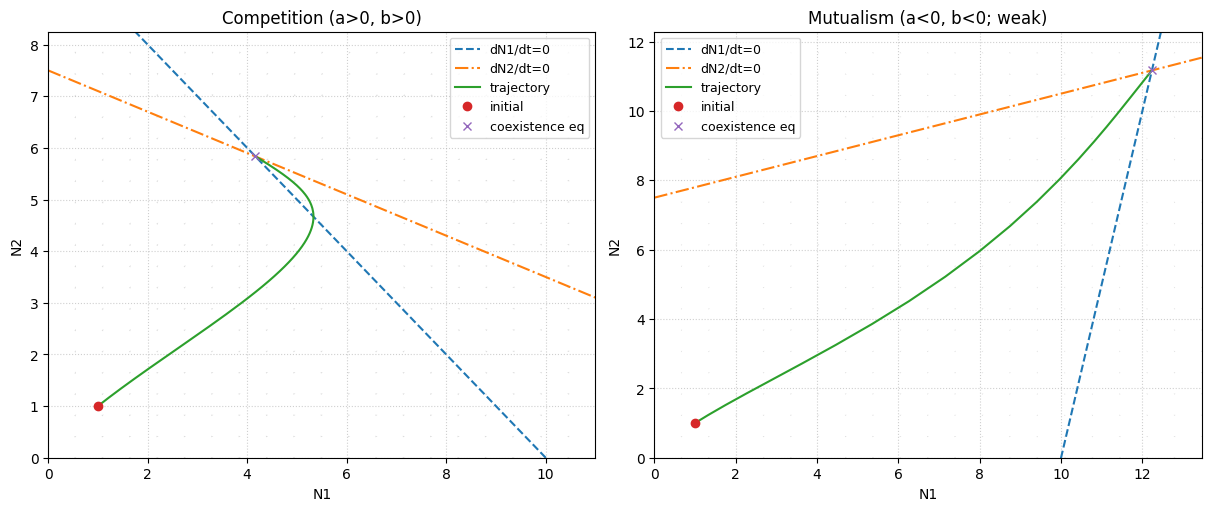

In [8]:
def add_vector_field(ax, rhs, xlim, ylim, args=(), density=21, normalize=True, color='0.6', alpha=0.35):

    """Add a light vector field (quiver) to a 2D phase-plane axis."""

    xs = np.linspace(xlim[0], xlim[1], density)

    ys = np.linspace(ylim[0], ylim[1], density)

    X, Y = np.meshgrid(xs, ys)



    U = np.zeros_like(X, dtype=float)

    V = np.zeros_like(Y, dtype=float)

    for i in range(X.shape[0]):

        for j in range(X.shape[1]):

            u, v = rhs(0.0, [float(X[i, j]), float(Y[i, j])], *args)

            U[i, j] = u

            V[i, j] = v



    if normalize:

        M = np.hypot(U, V)

        M[M == 0] = 1.0

        U = U / M

        V = V / M



    ax.quiver(

        X,

        Y,

        U,

        V,

        color=color,

        alpha=alpha,

        angles='xy',

        scale_units='xy',

        scale=25,

        width=0.0025,

        headwidth=3,

        headlength=4,

        pivot='mid',

        zorder=0,

    )





def plot_lv_phase(

    ax,

    *,

    r1,

    r2,

    k1,

    k2,

    a,

    b,

    y0=(1.0, 1.0),

    t_end=10.0,

    blowup_at=200.0,

    title="",

    show_vector_field=True,

    vf_density=21,

):

    def blowup_event(t, y, *args):

        # Stop integration if we get runaway growth (common in strong mutualism)

        return blowup_at - max(y)



    blowup_event.terminal = True

    blowup_event.direction = -1



    t_eval = np.linspace(0, t_end, 800)

    sol = solve_ivp(

        lv_rhs,

        (0, t_end),

        list(y0),

        t_eval=t_eval,

        args=(r1, r2, k1, k2, a, b),

        rtol=1e-9,

        atol=1e-12,

        events=blowup_event,

    )



    n1, n2 = sol.y

    denom = 1 - a * b

    if abs(denom) < 1e-12:

        n1_star, n2_star = np.nan, np.nan

    else:

        n1_star = (k1 - a * k2) / denom

        n2_star = (k2 - b * k1) / denom



    n1_lim = 1.1 * np.nanmax([k1, n1.max(initial=k1), n1_star if np.isfinite(n1_star) else k1])

    n2_lim = 1.1 * np.nanmax([k2, n2.max(initial=k2), n2_star if np.isfinite(n2_star) else k2])

    n1_lim = max(n1_lim, 1.0)

    n2_lim = max(n2_lim, 1.0)



    if show_vector_field:

        add_vector_field(

            ax,

            lv_rhs,

            (0, n1_lim),

            (0, n2_lim),

            args=(r1, r2, k1, k2, a, b),

            density=vf_density,

        )



    n1_grid = np.linspace(0, n1_lim, 400)

    iso1, iso2 = isoclines(n1_grid, k1, k2, a, b)



    ax.plot(n1_grid, iso1, '--', label='dN1/dt=0')

    ax.plot(n1_grid, iso2, '-.', label='dN2/dt=0')

    ax.plot(n1, n2, label='trajectory')

    ax.plot([y0[0]], [y0[1]], marker='o', linestyle='none', label='initial')

    if np.isfinite(n1_star) and np.isfinite(n2_star):

        ax.plot([n1_star], [n2_star], marker='x', linestyle='none', label='coexistence eq')



    ax.set_xlim(0, n1_lim)

    ax.set_ylim(0, n2_lim)

    ax.set_xlabel("N1")

    ax.set_ylabel("N2")

    ax.set_title(title)

    ax.grid(True, linestyle=':', alpha=0.6)



    if sol.status == 1:

        ax.text(

            0.02,

            0.98,

            f"Stopped early (runaway > {blowup_at:g})",

            transform=ax.transAxes,

            ha='left',

            va='top',

            fontsize=9,

        )





# Two illustrative parameter sets: competition vs (weak) mutualism

r1 = r2 = 1.0

y0 = (1.0, 1.0)



fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)



# Competition example (a,b > 0)

plot_lv_phase(

    axes[0],

    r1=r1,

    r2=r2,

    k1=10.0,

    k2=7.5,

    a=1.0,

    b=0.4,

    y0=y0,

    t_end=10.0,

    title="Competition (a>0, b>0)",

)



# Mutualism example (a,b < 0) — choose weak mutualism so the coexistence equilibrium is finite

plot_lv_phase(

    axes[1],

    r1=r1,

    r2=r2,

    k1=10.0,

    k2=7.5,

    a=-0.2,

    b=-0.3,

    y0=y0,

    t_end=25.0,

    blowup_at=200.0,

    title="Mutualism (a<0, b<0; weak)",

)



axes[0].legend(loc='best', fontsize=9)

axes[1].legend(loc='best', fontsize=9)

plt.show()


---

## A bounded mutualism extension (saturating benefits)

The linear LV form treats the interspecific effect as proportional to the partner’s density (e.g., $-aN_2$ in species 1’s bracket). For mutualism ($a<0$), this creates **positive feedback** and can predict **unbounded growth** when mutualistic effects are strong ($ab\ge 1$).

A simple way to keep the *same basic idea* (partner increases your per-capita growth) while preventing runaway is to make the benefit **saturate** with partner density, e.g. with a Michaelis–Menten / Holling type-II form:

$$
\dot N_1 = r_1 N_1\left(k_1 - N_1 - a\,\frac{N_2}{h_2 + N_2}\right),\qquad
\dot N_2 = r_2 N_2\left(k_2 - N_2 - b\,\frac{N_1}{h_1 + N_1}\right).
$$

Here $h_1,h_2>0$ are half-saturation constants. If $a<0$, then $-a\,\frac{N_2}{h_2+N_2}$ is a **bounded positive** contribution (at most $|a|$), so the feedback cannot grow without limit.


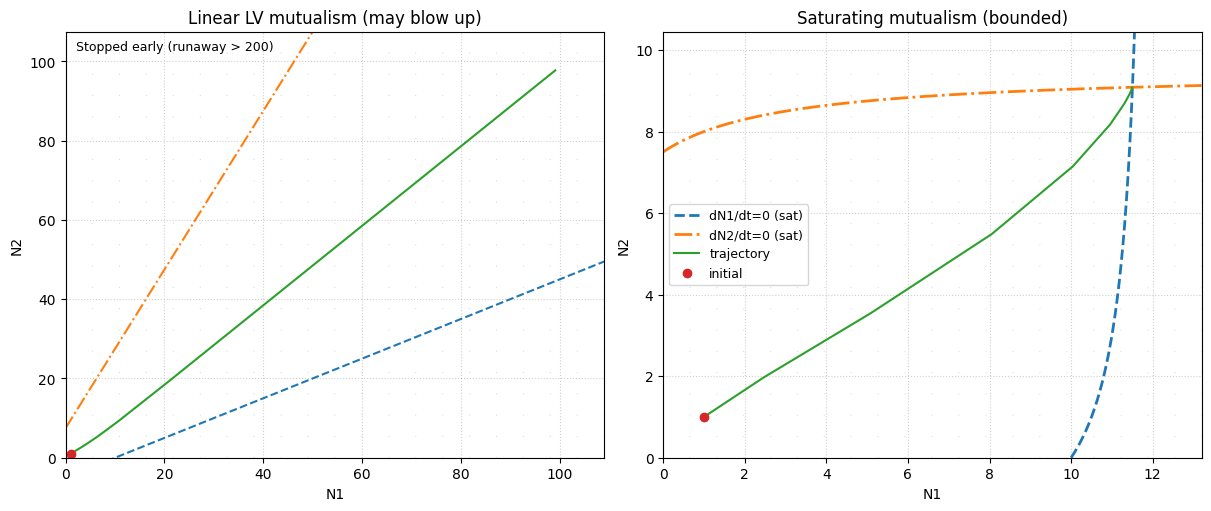

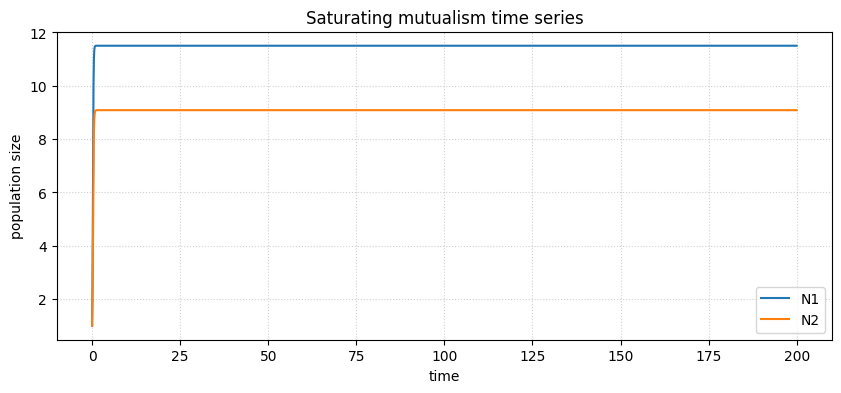

In [9]:
def lv_saturating_rhs(t, y, r1, r2, k1, k2, a, b, h1=3.0, h2=3.0):

    n1, n2 = y

    sat_12 = n2 / (h2 + n2)  # effect of species 2 on species 1 (bounded in [0,1))

    sat_21 = n1 / (h1 + n1)  # effect of species 1 on species 2

    dn1 = r1 * n1 * (k1 - n1 - a * sat_12)

    dn2 = r2 * n2 * (k2 - n2 - b * sat_21)

    return [dn1, dn2]





def plot_saturating_mutualism_demo():

    r1 = r2 = 1.0

    k1, k2 = 10.0, 7.5

    h1 = h2 = 3.0

    y0 = (1.0, 1.0)



    # Choose strong mutualistic coefficients that would cause runaway in *linear* LV

    # (for example, a=b=-2 gives ab=4>1). With saturation, the benefit is bounded.

    a = -2.0

    b = -2.0



    fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)



    # Left: linear LV with strong mutualism (usually blows up; we stop early via event)

    plot_lv_phase(

        axes[0],

        r1=r1,

        r2=r2,

        k1=k1,

        k2=k2,

        a=a,

        b=b,

        y0=y0,

        t_end=25.0,

        blowup_at=200.0,

        title="Linear LV mutualism (may blow up)",

    )



    # Right: saturating mutualism stays bounded

    t_eval = np.linspace(0, 200, 2000)

    sol = solve_ivp(

        lv_saturating_rhs,

        (0, 200),

        list(y0),

        t_eval=t_eval,

        args=(r1, r2, k1, k2, a, b, h1, h2),

        rtol=1e-9,

        atol=1e-12,

    )



    n1, n2 = sol.y



    # Vector field + nullclines for the saturating model

    n1_max = 1.1 * (k1 + abs(a))

    n2_max = 1.1 * (k2 + abs(b))

    add_vector_field(

        axes[1],

        lv_saturating_rhs,

        (0, n1_max),

        (0, n2_max),

        args=(r1, r2, k1, k2, a, b, h1, h2),

        density=21,

    )



    # Nullclines for the saturating model (positive-density branches)

    # dn1=0 (for n1>0): n1 = k1 - a * n2/(h2+n2)

    # dn2=0 (for n2>0): n2 = k2 - b * n1/(h1+n1)

    n1_grid = np.linspace(0, n1_max, 500)

    n2_grid = np.linspace(0, n2_max, 500)

    n1_null = k1 - a * (n2_grid / (h2 + n2_grid))

    n2_null = k2 - b * (n1_grid / (h1 + n1_grid))



    axes[1].plot(n1_null, n2_grid, '--', linewidth=2, label='dN1/dt=0 (sat)')

    axes[1].plot(n1_grid, n2_null, '-.', linewidth=2, label='dN2/dt=0 (sat)')

    axes[1].plot(n1, n2, label='trajectory')

    axes[1].plot([y0[0]], [y0[1]], marker='o', linestyle='none', label='initial')



    axes[1].set_xlim(0, n1_max)

    axes[1].set_ylim(0, n2_max)

    axes[1].set_xlabel('N1')

    axes[1].set_ylabel('N2')

    axes[1].set_title('Saturating mutualism (bounded)')

    axes[1].grid(True, linestyle=':', alpha=0.6)

    axes[1].legend(loc='best', fontsize=9)



    plt.show()



    # Optional: time series for bounded case

    plt.figure(figsize=(10, 4))

    plt.plot(sol.t, n1, label='N1')

    plt.plot(sol.t, n2, label='N2')

    plt.xlabel('time')

    plt.ylabel('population size')

    plt.title('Saturating mutualism time series')

    plt.grid(True, linestyle=':', alpha=0.6)

    plt.legend()

    plt.show()





plot_saturating_mutualism_demo()


### Four canonical outcomes

The classical LV competition model yields four qualitative outcomes depending on how the isoclines intersect. Geometrically, the key idea is that isoclines act like “decision boundaries” for the sign of $\dot N_1$ and $\dot N_2$; the way those boundaries are nested (which one lies “outside” the other) determines whether trajectories are driven to a boundary equilibrium (exclusion) or to an interior point (coexistence).

1. **Species 1 excludes species 2**: stable equilibrium $(k_1,0)$
2. **Species 2 excludes species 1**: stable equilibrium $(0,k_2)$
3. **Stable coexistence**: a stable interior equilibrium $(N_1^*,N_2^*)$ exists
4. **Alternative stable states (bistability)**: both $(k_1,0)$ and $(0,k_2)$ are stable; an interior saddle separates basins

In the practical, parameter set 1 corresponds to stable coexistence, while parameter set 2 corresponds to alternative stable states.

References: {cite:t}`May1973`; {cite:t}`Case2000`; {cite:t}`Kot2001`.


---

## Equilibria and local stability

### Equilibria

Equilibria (fixed points) are population states where both species have zero net growth. In two-dimensional systems like this, equilibria and their stability types (stable node, saddle, etc.) provide a compact “map” of long-term behaviour.

Setting $\dot N_1=\dot N_2=0$ gives the candidate equilibria:

- $E_{00}=(0,0)$
- $E_{10}=(k_1,0)$
- $E_{01}=(0,k_2)$
- $E_{\mathrm{co}}$ = intersection of the non-trivial isoclines:

$$
\begin{bmatrix}1 & a\\ b & 1\end{bmatrix}
\begin{bmatrix}N_1^*\\ N_2^*\end{bmatrix}
=
\begin{bmatrix}k_1\\ k_2\end{bmatrix}
\Rightarrow
N_1^*=\frac{k_1-a k_2}{1-ab},\quad
N_2^*=\frac{k_2-b k_1}{1-ab}.
$$

Feasibility requires $N_1^*,N_2^* \ge 0$.

**Competition vs mutualism in this form.** For competition ($a,b>0$), the coexistence equilibrium can fail to be feasible if interspecific effects are too strong (e.g., $a$ or $b$ large). For mutualism ($a,b<0$), the numerators above are typically positive, but feasibility now hinges on the denominator: you need
$$
1-ab > 0\quad\Leftrightarrow\quad ab < 1.
$$
If $a<0$ and $b<0$ are large in magnitude such that $ab\ge 1$, the model predicts runaway positive feedback (no finite positive coexistence equilibrium). This is why mutualism is often modelled with saturating benefits rather than strictly linear cross terms.

References: {cite:t}`May1973`; {cite:t}`Strogatz1994`; {cite:t}`Kot2001`.


### Jacobian and eigenvalues

Local stability is assessed by linearising the system near an equilibrium. The Jacobian $J$ captures how small perturbations grow or shrink; its eigenvalues determine whether trajectories return to the equilibrium (stable) or depart (unstable). This is the standard linear-stability toolkit used throughout dynamical systems and theoretical ecology.

Define $f_1(N_1,N_2)=r_1N_1(k_1-N_1-aN_2)$ and $f_2(N_1,N_2)=r_2N_2(k_2-bN_1-N_2)$.

The Jacobian is:

$$
J=
\begin{pmatrix}
\partial f_1/\partial N_1 & \partial f_1/\partial N_2\\
\partial f_2/\partial N_1 & \partial f_2/\partial N_2
\end{pmatrix}.
$$

A fixed point is **locally stable** if both eigenvalues have negative real parts.

References: {cite:t}`Strogatz1994`; {cite:t}`Hirsch2012`; {cite:t}`Kot2001`.


In [12]:
def jacobian(n1, n2, r1, r2, k1, k2, a, b):
    df1_dn1 = r1*(k1 - n1 - a*n2) + r1*n1*(-1)
    df1_dn2 = r1*n1*(-a)
    df2_dn1 = r2*n2*(-b)
    df2_dn2 = r2*(k2 - b*n1 - n2) + r2*n2*(-1)
    return np.array([[df1_dn1, df1_dn2],
                     [df2_dn1, df2_dn2]])

def equilibria(k1, k2, a, b):
    E00=(0.0,0.0)
    E10=(k1,0.0)
    E01=(0.0,k2)
    denom = 1 - a*b
    Eco=(np.nan,np.nan) if abs(denom)<1e-12 else ((k1-a*k2)/denom, (k2-b*k1)/denom)
    return [E00,E10,E01,Eco]

def classify(eq, r1,r2,k1,k2,a,b):
    J=jacobian(eq[0],eq[1],r1,r2,k1,k2,a,b)
    ev=eigvals(J)
    stable=np.all(np.real(ev)<0)
    feasible=(eq[0]>=-1e-9) and (eq[1]>=-1e-9)
    return ev, stable, feasible

# Example parameter set (coexistence case, same as practical Set A)
r1 = r2 = 1.0
k1_1, k2_1 = 10.0, 7.5
a_1, b_1 = 1.0, 0.4

E = equilibria(k1_1, k2_1, a_1, b_1)
for lab, eq in zip(["E00","E10","E01","Eco"], E):
    ev, st, feas = classify(eq, r1, r2, k1_1, k2_1, a_1, b_1)
    print(lab, eq, "feasible=", feas, "stable=", st, "eigs=", ev)

E00 (0.0, 0.0) feasible= True stable= False eigs= [10.   7.5]
E10 (10.0, 0.0) feasible= True stable= False eigs= [-10.    3.5]
E01 (0.0, 7.5) feasible= True stable= False eigs= [-7.5  2.5]
Eco (4.166666666666667, 5.833333333333334) feasible= True stable= True eigs= [-1.77251388 -8.22748612]


---

## Bifurcations, catastrophic shifts, and hysteresis

Many ecological systems show **nonlinear feedbacks** that can create:
- multiple equilibria (alternative stable states)
- sudden transitions when parameters cross thresholds (catastrophic shifts)
- hysteresis (different forward vs reverse transition points)

Mathematically, these phenomena often arise from bifurcations (qualitative changes in phase-plane structure as parameters vary). Ecologically, they are linked to resilience and “tipping points”, where gradual environmental change can produce abrupt regime shifts.

We illustrate two “worked” examples used in the lectures/practical:
1) LV competition bistability (parameter set 2)  
2) A minimal positive-feedback model producing hysteresis (Scheffer-style)

### LV bistability as a threshold phenomenon

Using the practical’s parameter set 2:
- $k_1=12, k_2=15, a=1.2, b=1.8, r_1=r_2=1$

the system has two stable boundary equilibria and an interior saddle. The saddle’s stable manifold acts as a **separatrix**, dividing initial conditions that end at different stable states (a simple mechanism for alternative stable states).

References: {cite:t}`May1977`; {cite:t}`Scheffer2001`; {cite:t}`Scheffer2009`.


In [11]:
# Parameter set 2 (matches lvcomp2.ode)
r1=r2=1.0
k1_2, k2_2 = 12.0, 15.0
a_2, b_2 = 1.2, 1.8

E = equilibria(k1_2,k2_2,a_2,b_2)
for lab,eq in zip(["E00","E10","E01","Eco"],E):
    ev, st, feas = classify(eq,r1,r2,k1_2,k2_2,a_2,b_2)
    print(lab, eq, "feasible=",feas, "stable=",st, "eigs=",ev)

E00 (0.0, 0.0) feasible= True stable= False eigs= [12. 15.]
E10 (12.0, 0.0) feasible= True stable= True eigs= [-12.   -6.6]
E01 (0.0, 15.0) feasible= True stable= True eigs= [-15.  -6.]
Eco (5.1724137931034475, 5.689655172413794) feasible= True stable= False eigs= [  2.54606189 -13.40813086]


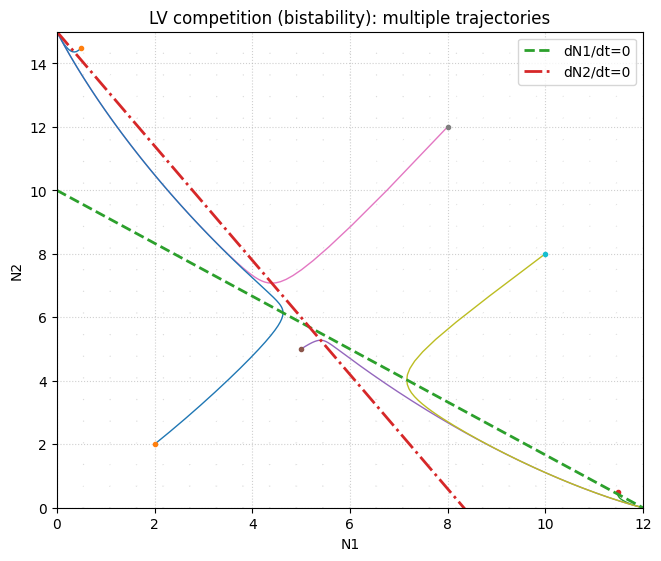

In [13]:
# Phase portrait for bistability

n1_grid = np.linspace(0, 12, 400)

iso1, iso2 = isoclines(n1_grid, k1_2, k2_2, a_2, b_2)



fig, ax = plt.subplots(figsize=(6.5, 5.5), constrained_layout=True)



# Add a light vector field behind trajectories

add_vector_field(ax, lv_rhs, (0, 12), (0, 15), args=(r1, r2, k1_2, k2_2, a_2, b_2), density=23)



for y0 in ([0.5,14.5],[11.5,0.5],[5,5],[8,12],[10,8],[2,2]):

    sol = solve_ivp(

        lv_rhs,

        (0, 12),

        y0,

        t_eval=np.linspace(0, 12, 600),

        args=(r1, r2, k1_2, k2_2, a_2, b_2),

        rtol=1e-8,

        atol=1e-10,

    )

    ax.plot(sol.y[0], sol.y[1], linewidth=1)

    ax.plot([y0[0]], [y0[1]], marker='o', markersize=3, linestyle='none')



ax.plot(n1_grid, iso1, '--', linewidth=2, label='dN1/dt=0')

ax.plot(n1_grid, iso2, '-.', linewidth=2, label='dN2/dt=0')

ax.set_xlim(0, 12)

ax.set_ylim(0, 15)

ax.set_xlabel("N1")

ax.set_ylabel("N2")

ax.set_title("LV competition (bistability): multiple trajectories")

ax.legend()

ax.grid(True, linestyle=':', alpha=0.6)

plt.show()


### A minimal hysteresis model (positive feedback)

A standard toy model for catastrophic shifts is a linear input/loss term plus a saturating positive feedback (often represented with a Hill function). This class of models is used to illustrate how the *same* external driver can be associated with different equilibria depending on history (hysteresis).

$$
\dot x = a - b x + r f(x),\qquad
f(x)=\frac{x^p}{x^p+h^p}.
$$

- $a-bx$: linear input/loss
- $r f(x)$: positive feedback that saturates

For suitable $r$, this system can have **three equilibria** (two stable + one unstable), producing hysteresis.

We'll reproduce a simple “quasi-static” hysteresis loop by slowly increasing then decreasing $r$, each time re-using the last equilibrium as the initial condition.

References: {cite:t}`Scheffer2001`; {cite:t}`Scheffer2009`; {cite:t}`Strogatz1994`.


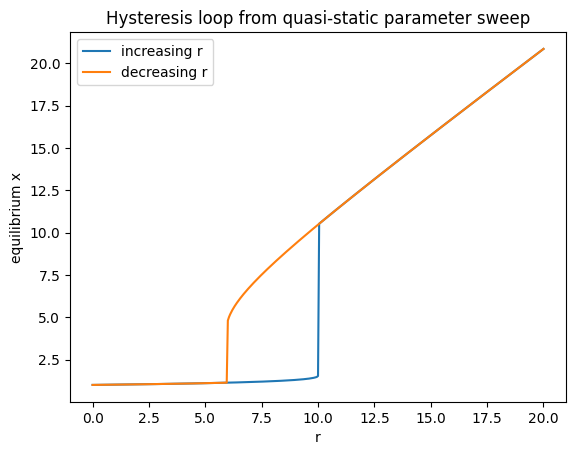

In [7]:
def hill(x, h=4, p=3):
    return x**p/(x**p + h**p)

def hyster_rhs(t, x, a=1, b=1, r=0, h=4, p=3):
    return a - b*x + r*hill(x, h=h, p=p)

def relax_equilibrium(r, x0, a=1, b=1, h=4, p=3):
    sol = solve_ivp(lambda t, x: hyster_rhs(t, x, a=a, b=b, r=r, h=h, p=p),
                    (0, 200), [x0], t_eval=np.linspace(0,200,2000),
                    rtol=1e-9, atol=1e-12)
    return sol.y[0,-1]

a=1; b=1; h=4; p=3
rs_up = np.linspace(0, 20, 401)
rs_dn = np.linspace(20, 0, 401)

x_up=[]
x=0.1
for r in rs_up:
    x=relax_equilibrium(r, x, a=a,b=b,h=h,p=p)
    x_up.append(x)

x_dn=[]
x=x_up[-1]
for r in rs_dn:
    x=relax_equilibrium(r, x, a=a,b=b,h=h,p=p)
    x_dn.append(x)

plt.figure()
plt.plot(rs_up, x_up, label="increasing r")
plt.plot(rs_dn, x_dn, label="decreasing r")
plt.xlabel("r"); plt.ylabel("equilibrium x")
plt.title("Hysteresis loop from quasi-static parameter sweep")
plt.legend()
plt.show()

#### Notes on the “missing branch”

The quasi-static sweep follows **stable equilibria only**.  
Where three equilibria exist, the middle one is unstable, so it will not be traced by forward integration.

Continuation tools (e.g., AUTO) can trace unstable branches. In Python, you can recover them by solving the equilibrium equation
$0 = a - bx + r f(x)$ with root finding using different initial guesses.

References: {cite:t}`Kuznetsov2004`; {cite:t}`Strogatz1994`.
